In [1]:
%load_ext dotenv
%dotenv -o ..//.env.local

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import os
import psycopg
from psycopg.rows import dict_row

with psycopg.connect(f"host={os.getenv('PGHOST')} port={os.getenv('PGPORT')} dbname={os.getenv('PGDATABASE')} user={os.getenv('PGUSER')} password={os.getenv('PGPASSWORD')}", row_factory=dict_row) as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT * FROM bidding_results ORDER BY month DESC, exercise DESC, vehicle_category")
        records = cur.fetchall()
        bidding_results = pd.DataFrame(records)
        cur.execute("SELECT * FROM realtime_status ORDER BY month DESC, exercise DESC, vehicle_category, timestamp DESC")
        records = cur.fetchall()
        realtime_status = pd.DataFrame(records)

In [4]:
bidding_results['month_exercise'] = bidding_results['month'] + '/' + bidding_results['exercise']
bidding_results = bidding_results[bidding_results['month_exercise'] >= '2018-10/2']
bidding_results

,month,exercise,vehicle_category,last_updated,quota,quota_premium,bids_received,bids_successful,month_exercise
0,2022-03,1,A,2022-03-14,531,68501.0,962.0,526.0,2022-03/1
1,2022-03,1,B,2022-03-14,551,94889.0,860.0,551.0,2022-03/1
2,2022-03,1,C,2022-03-14,76,48889.0,199.0,67.0,2022-03/1
3,2022-03,1,D,2022-03-14,405,11400.0,602.0,403.0,2022-03/1
4,2022-03,1,E,2022-03-14,190,98890.0,318.0,190.0,2022-03/1
...,...,...,...,...,...,...,...,...,...
380,2018-10,2,A,2018-11-05,1674,25556.0,1811.0,1672.0,2018-10/2
381,2018-10,2,B,2018-11-05,1273,31302.0,1856.0,1267.0,2018-10/2
382,2018-10,2,C,2018-11-05,350,29501.0,470.0,349.0,2018-10/2
383,2018-10,2,D,2018-11-05,819,3951.0,1201.0,819.0,2018-10/2


In [5]:
realtime_status = realtime_status[realtime_status['month'] != '2020-04']
realtime_status['timestamp'] = realtime_status['timestamp'].dt.tz_convert('UTC')
realtime_status['date'] = realtime_status['timestamp'].dt.date
realtime_status['time'] = realtime_status['timestamp'].dt.time
realtime_status['day_of_week'] = realtime_status['timestamp'].dt.day_of_week
realtime_status

,timestamp,month,exercise,vehicle_category,current_bids,current_price,date,time,day_of_week
0,2022-03-09 07:58:17+00:00,2022-03,1,A,941,67400,2022-03-09,07:58:17,2
1,2022-03-09 07:57:37+00:00,2022-03,1,A,931,67000,2022-03-09,07:57:37,2
2,2022-03-09 07:56:17+00:00,2022-03,1,A,916,66733,2022-03-09,07:56:17,2
3,2022-03-09 07:55:37+00:00,2022-03,1,A,904,66309,2022-03-09,07:55:37,2
4,2022-03-09 07:54:17+00:00,2022-03,1,A,900,66010,2022-03-09,07:54:17,2
...,...,...,...,...,...,...,...,...,...
293946,2018-10-15 04:15:25+00:00,2018-10,2,E,0,1,2018-10-15,04:15:25,0
293947,2018-10-15 04:14:05+00:00,2018-10,2,E,0,1,2018-10-15,04:14:05,0
293948,2018-10-15 04:13:25+00:00,2018-10,2,E,0,1,2018-10-15,04:13:25,0
293949,2018-10-15 04:12:45+00:00,2018-10,2,E,0,1,2018-10-15,04:12:45,0


In [6]:
merged_realtime_status = pd.merge(realtime_status, bidding_results, on=['month', 'exercise', 'vehicle_category'], how='left')
merged_realtime_status = merged_realtime_status.dropna(subset=['quota_premium'])

In [7]:
merged_realtime_status['demand'] = merged_realtime_status['bids_received'] - (merged_realtime_status['current_bids'] - merged_realtime_status['quota'])
merged_realtime_status['reservation_price'] = merged_realtime_status['current_price'] - 1
merged_realtime_status['percent_final_price'] = merged_realtime_status['current_price'] / merged_realtime_status['quota_premium']
merged_realtime_status['percent_bids_in'] = merged_realtime_status['current_bids'] / merged_realtime_status['bids_received']

In [8]:
merged_realtime_status['time_to_closing'] = (
    pd.to_datetime(merged_realtime_status.groupby(['month', 'exercise'])['date'].transform('max')) + pd.Timedelta(hours=8)
).dt.tz_localize('UTC') - merged_realtime_status['timestamp']
merged_realtime_status['percent_to_closing'] = 1 - merged_realtime_status['time_to_closing'] / pd.Timedelta(hours=8)

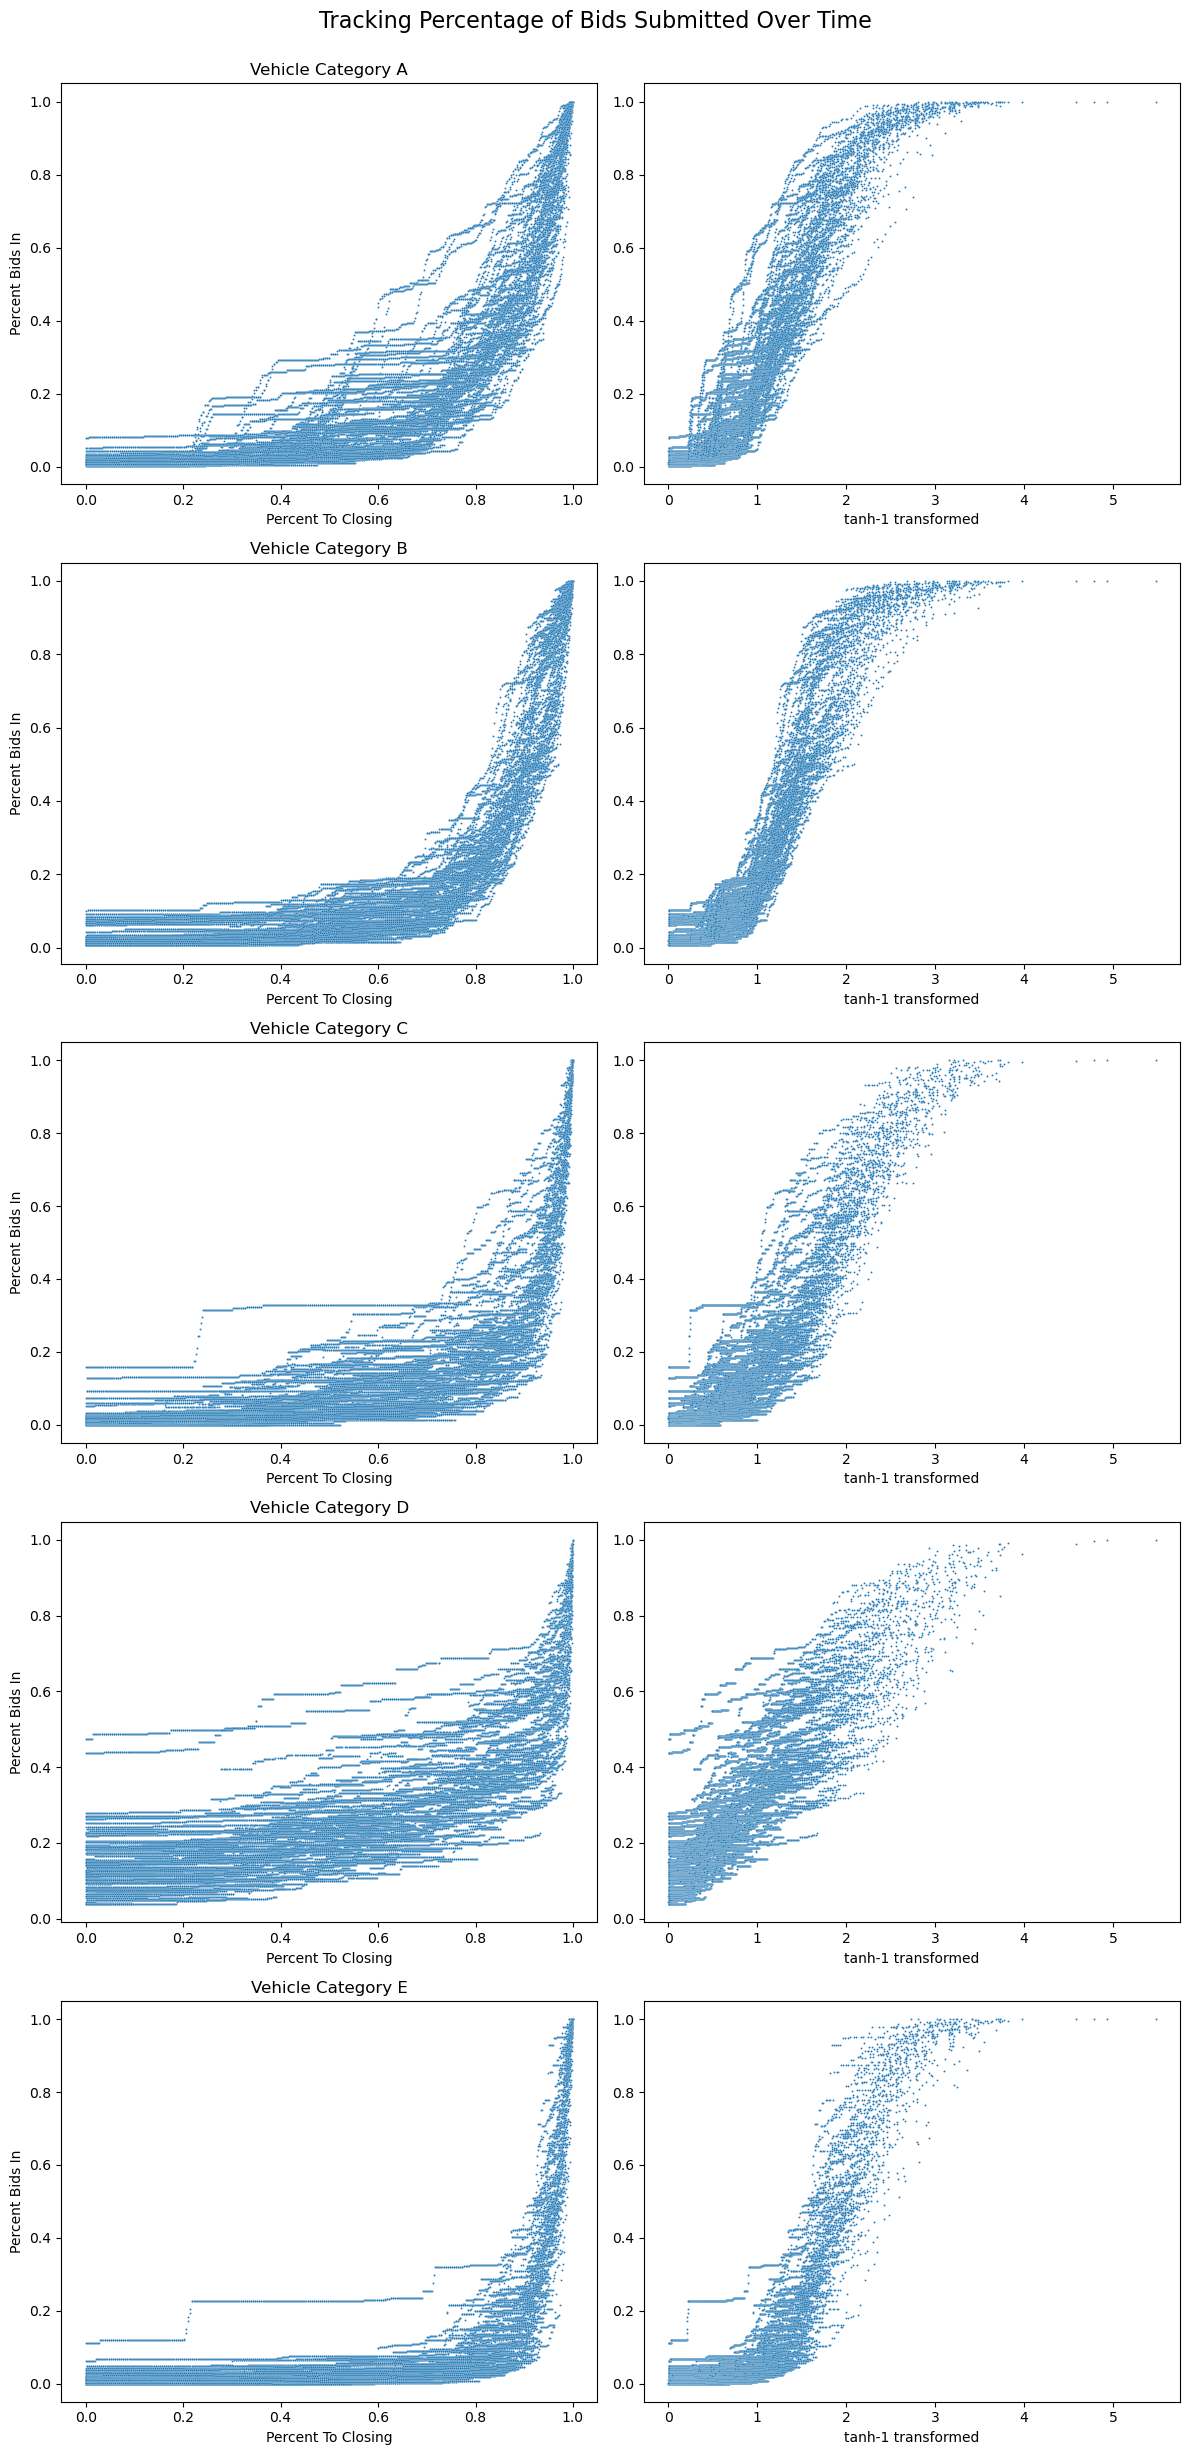

In [9]:
filtered = merged_realtime_status[(merged_realtime_status['percent_to_closing'] >= 0) & (merged_realtime_status['percent_to_closing'] < 1)].copy()
filtered['arctanh_x'] = np.arctanh(filtered['percent_to_closing'])
filtered['x'] = filtered['percent_to_closing']
filtered['y'] = filtered['percent_bids_in']

all_categories = sorted(bidding_results['vehicle_category'].unique())

fig, axes = plt.subplots(len(all_categories), 2, figsize=(12, 5 * len(all_categories)))

# Plot for each vehicle category
for i, category in enumerate(all_categories):
    category_data = filtered[filtered['vehicle_category'] == category]
    
    # Plot x/y scatter
    sns.scatterplot(data=category_data, x='x', y='y', s=2, ax=axes[i, 0])
    axes[i, 0].set_title(f'Vehicle Category {category}')
    axes[i, 0].set_xlabel('Percent To Closing')
    axes[i, 0].set_ylabel('Percent Bids In')
    
    
    # Plot arctanh_x/y scatter
    sns.scatterplot(data=category_data, x='arctanh_x', y='y', s=2, ax=axes[i, 1])
    axes[i, 1].set_xlabel('tanh-1 transformed')
    axes[i, 1].set_ylabel('')

fig.suptitle('Tracking Percentage of Bids Submitted Over Time', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])

In [10]:
filtered_20 = merged_realtime_status[merged_realtime_status['percent_bids_in'] >= 0.2]
time_20_bids_in = filtered_20.groupby(['month', 'exercise', 'vehicle_category'])['percent_to_closing'].min().reset_index()
time_20_bids_in.rename(columns={'percent_to_closing': 'time_20_bids_in'}, inplace=True)

filtered_50 = merged_realtime_status[merged_realtime_status['percent_bids_in'] >= 0.5]
time_50_bids_in = filtered_50.groupby(['month', 'exercise', 'vehicle_category'])['percent_to_closing'].min().reset_index()
time_50_bids_in.rename(columns={'percent_to_closing': 'time_50_bids_in'}, inplace=True)

filtered_80 = merged_realtime_status[merged_realtime_status['percent_bids_in'] >= 0.8]
time_80_bids_in = filtered_80.groupby(['month', 'exercise', 'vehicle_category'])['percent_to_closing'].min().reset_index()
time_80_bids_in.rename(columns={'percent_to_closing': 'time_80_bids_in'}, inplace=True)

time_percent_bids_in = time_20_bids_in.merge(time_50_bids_in, on=['month', 'exercise', 'vehicle_category'], how='outer')
time_percent_bids_in = time_percent_bids_in.merge(time_80_bids_in, on=['month', 'exercise', 'vehicle_category'], how='outer')

In [11]:
time_percent_bids_in['time_20_bids_in']

0      0.432118
1      0.783507
2      0.721007
3      0.466840
4      0.923785
         ...   
375    0.720035
376    0.758924
377    0.865868
378    0.578368
379    0.936701
Name: time_20_bids_in, Length: 380, dtype: float64

In [12]:
time_percent_bids_in.groupby('vehicle_category')[['time_20_bids_in', 'time_50_bids_in', 'time_80_bids_in']].median()

,time_20_bids_in,time_50_bids_in,time_80_bids_in
vehicle_category,,,
A,0.743854,0.902917,0.970851
B,0.784514,0.904271,0.962205
C,0.839531,0.948785,0.988108
D,0.423108,0.934045,0.993646
E,0.904444,0.961146,0.986007


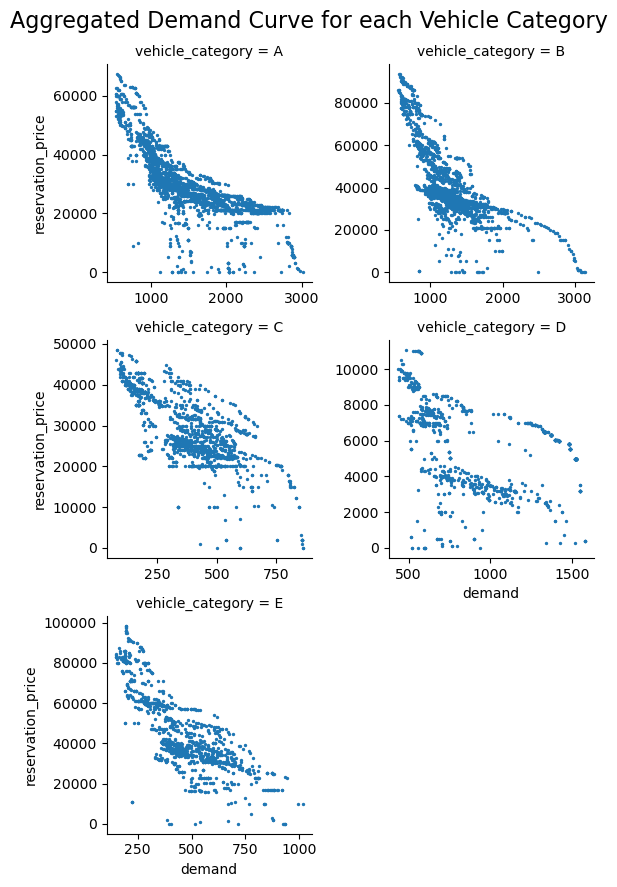

In [13]:
filtered = merged_realtime_status[merged_realtime_status['reservation_price'] > 0]
g = sns.FacetGrid(filtered, col='vehicle_category', col_wrap=2, sharex=False, sharey=False)
g.map(plt.scatter, 'demand', 'reservation_price', s = 2)
g.fig.suptitle('Aggregated Demand Curve for each Vehicle Category', fontsize=16)
g.tight_layout();

In [14]:
def fit_exponential(group):
    y = group['reservation_price']
    x = group['demand']
    
    coefficients = np.polyfit(x, np.log(y), 1)
    return pd.Series(coefficients, index=['a', 'b'])

filtered = merged_realtime_status[merged_realtime_status['percent_final_price'] >= 0.4]
filtered = filtered.drop_duplicates(subset=['month', 'exercise', 'vehicle_category', 'reservation_price', 'demand'])
filtered = filtered.groupby(['month', 'exercise', 'vehicle_category']).filter(lambda x: len(x) >= 5)
fitted_coefficients = filtered.groupby(['month', 'exercise', 'vehicle_category']).apply(fit_exponential, include_groups=False)

In [15]:
bidding_results_i = bidding_results.set_index(['month', 'exercise', 'vehicle_category'])
bidding_results_i['y_hat_0'] = np.exp(fitted_coefficients['b'] + fitted_coefficients['a'] * bidding_results_i['quota'])
bidding_results_i['y_hat_1'] = np.exp(fitted_coefficients['b'] + fitted_coefficients['a'] * bidding_results_i['bids_received'])
bidding_results_i['elasticity'] = 1 / fitted_coefficients['a'] / bidding_results_i['quota']
bidding_results = bidding_results_i.reset_index()

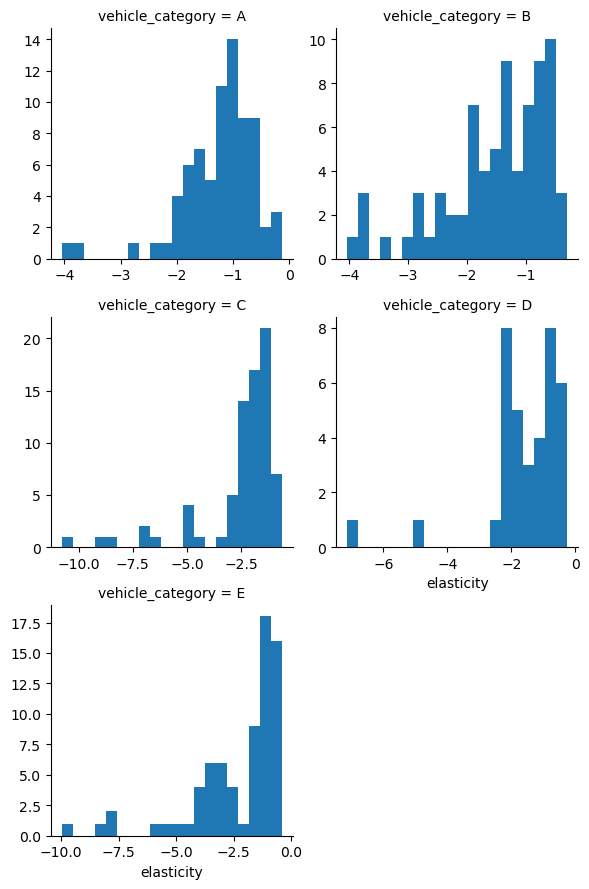

In [16]:
g = sns.FacetGrid(bidding_results_i.reset_index(), col='vehicle_category', col_wrap=2, sharex=False, sharey=False)
g.map(plt.hist, 'elasticity', bins=20);

In [17]:
bidding_results['excess_demand'] = (bidding_results['bids_received'] - bidding_results['quota']) / bidding_results['quota']
grouped_by_cat = bidding_results[bidding_results['month'] >= '2018-10'].groupby('vehicle_category')

pd.options.display.float_format = '{:,.0f}'.format
grouped_by_cat['quota_premium'].describe()

,count,mean,std,min,25%,50%,75%,max
vehicle_category,,,,,,,,
A,76,"38,537","10,585","23,568","30,910","35,850","45,872","68,501"
B,76,"48,404","16,852","30,012","36,721","41,231","56,597","94,889"
C,76,"32,426","7,622","22,002","25,542","29,045","39,692","48,889"
D,76,"6,263","2,536","2,509","3,769","7,300","8,501","11,400"
E,76,"49,993","17,728","30,851","37,839","41,252","59,700","98,890"


In [18]:
pd.options.display.float_format = '{:,.3f}'.format
grouped_by_cat['excess_demand'].describe()

,count,mean,std,min,25%,50%,75%,max
vehicle_category,,,,,,,,
A,76.000,0.445,0.213,0.082,0.328,0.398,0.496,1.375
B,76.000,0.450,0.224,0.143,0.293,0.425,0.562,1.448
C,76.000,0.692,0.252,0.264,0.527,0.663,0.844,1.618
D,76.000,0.355,0.105,0.199,0.291,0.329,0.396,0.854
E,76.000,0.594,0.208,0.278,0.445,0.552,0.662,1.145


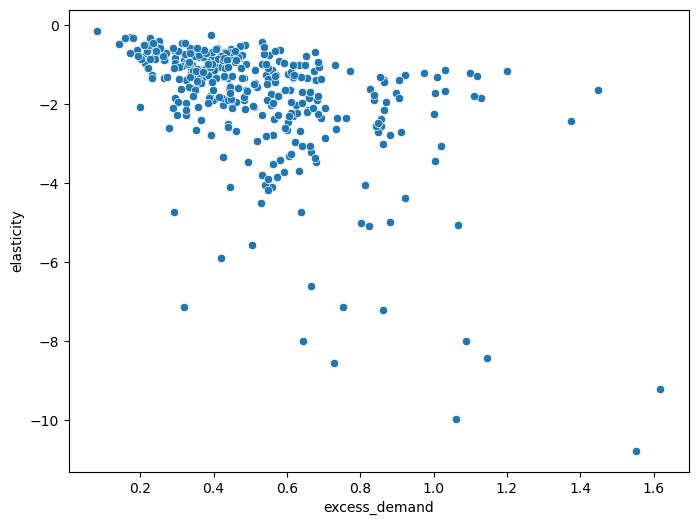

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=bidding_results, y='elasticity', x='excess_demand');

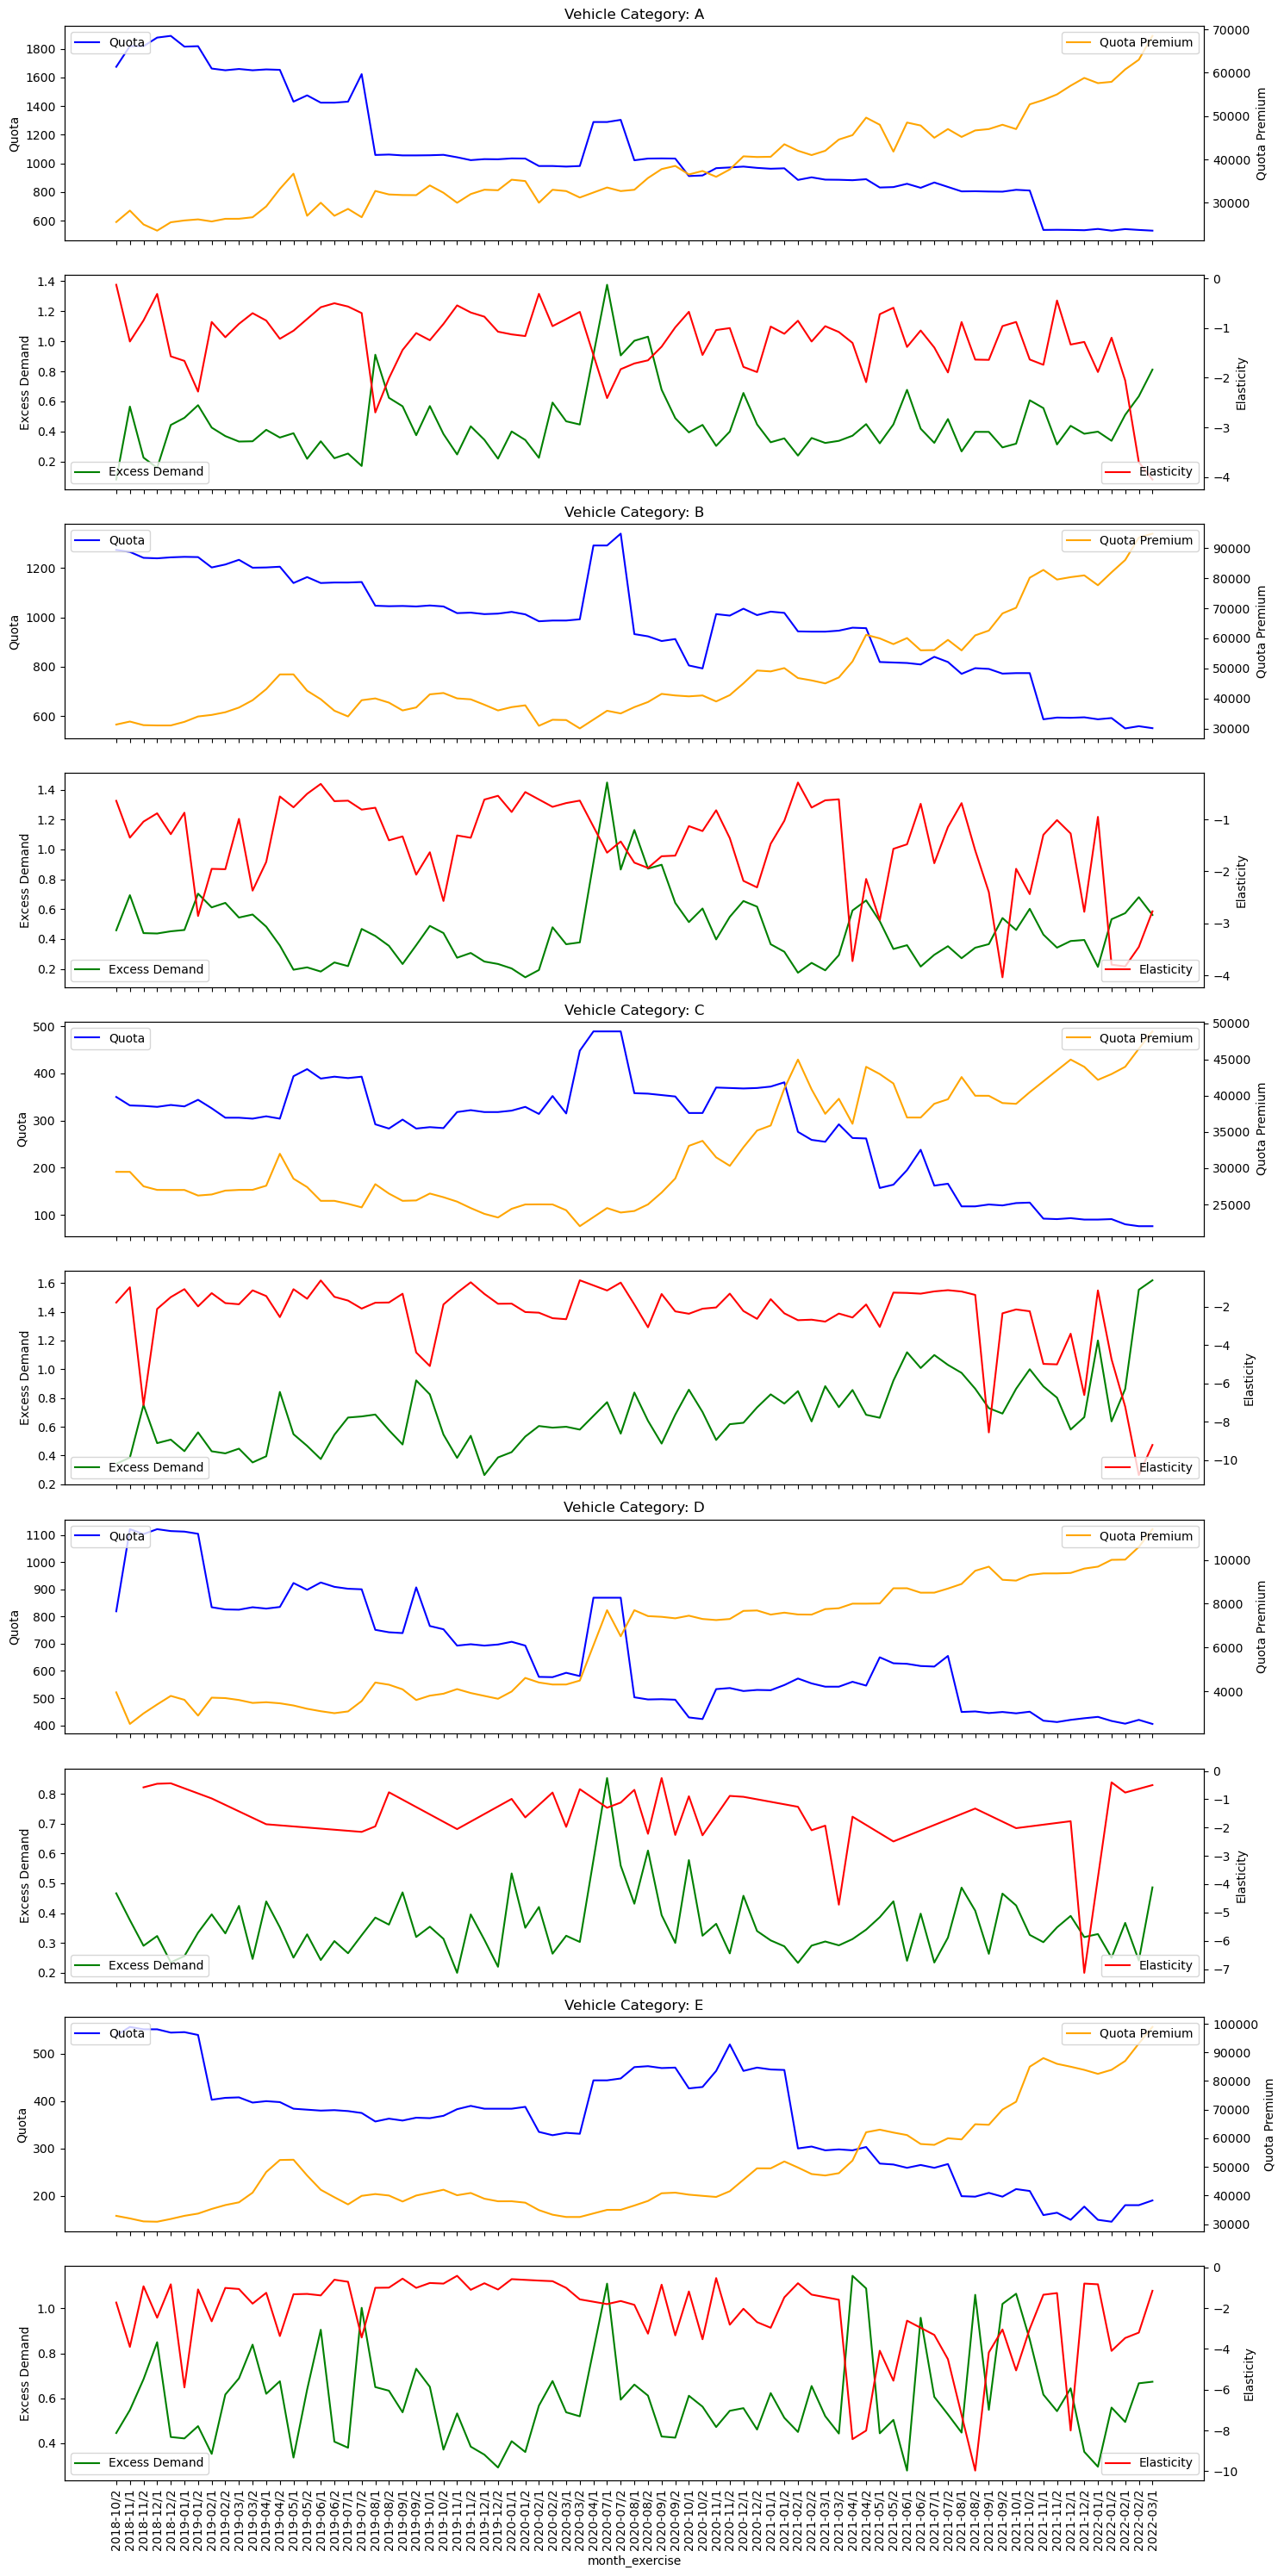

In [20]:
bidding_results_sorted = bidding_results.sort_values(['month_exercise', 'vehicle_category'])

# Get unique vehicle categories
all_categories = sorted(bidding_results['vehicle_category'].unique())

# Create subplots
fig, axes = plt.subplots(nrows=10, figsize=(15, 30), sharex='col')

# Plot each vehicle category in its own column
for i, category in enumerate(all_categories):
    data = bidding_results_sorted[bidding_results_sorted['vehicle_category'] == category]
    
    # Top facet: quota and quota_premium
    ax1 = axes[2 * i]
    ax2 = ax1.twinx()
    sns.lineplot(data=data, x='month_exercise', y='quota', label='Quota', color='blue', ax=ax1)
    sns.lineplot(data=data, x='month_exercise', y='quota_premium', label='Quota Premium', color='orange', ax=ax2)
    ax1.set_title(f'Vehicle Category: {category}')
    ax1.set_ylabel('Quota')
    ax2.set_ylabel('Quota Premium')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # Bottom facet: excess_demand and elasticity
    ax3 = axes[2 * i + 1]
    ax4 = ax3.twinx()
    sns.lineplot(data=data, x='month_exercise', y='excess_demand', label='Excess Demand', color='green', ax=ax3)
    sns.lineplot(data=data, x='month_exercise', y='elasticity', label='Elasticity', color='red', ax=ax4)
    ax3.set_ylabel('Excess Demand')
    ax4.set_ylabel('Elasticity')
    ax3.legend(loc='lower left')
    ax4.legend(loc='lower right')

for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.tight_layout()

In [21]:
import ipywidgets as widgets
from ipywidgets import interact
from matplotlib.ticker import FuncFormatter

# Extract all 'month_exercise' and 'vehicle_category' and sort ascendingly
all_exercises = sorted(bidding_results['month_exercise'].unique())
all_categories = sorted(bidding_results['vehicle_category'].unique())

scatter_data = merged_realtime_status[merged_realtime_status['reservation_price'] > 0].groupby(['month', 'exercise', 'vehicle_category'])

def plot_demand_curve(selected_exercise):
    k = all_exercises.index(selected_exercise)
    selected_exercises = [all_exercises[k-2], all_exercises[k-1], all_exercises[k]]

    fig, axes = plt.subplots(len(all_categories), 3, figsize=(20, 24), sharex=False, sharey=False)
    axes = axes.flatten()

    # Collect y-limits for each row
    y_limits = [[float('inf'), float('-inf')] for _ in range(len(all_categories))]

    for i, ax in enumerate(axes):
        exercise_index = i % 3
        category_index = i // 3
        
        month_exercise = selected_exercises[exercise_index]
        month, exercise = month_exercise.split('/')
        vehicle_category = all_categories[category_index]
        
        matched_bidding_results = bidding_results_i.loc[month, exercise, vehicle_category]
        
        # Check if the key exists in fitted_coefficients
        if (month, exercise, vehicle_category) in fitted_coefficients.index:
            matched_coefficients = fitted_coefficients.loc[month, exercise, vehicle_category]
        else:
            matched_coefficients = None

        filtered_status = scatter_data.get_group((month, exercise, vehicle_category))

        # Extract relevant values
        quota = matched_bidding_results['quota']
        bids_received = matched_bidding_results['bids_received']
        y_hat_0 = matched_bidding_results.get('y_hat_0', None)
        y_hat_1 = matched_bidding_results.get('y_hat_1', None)

        # Plot the demand curve if coefficients are available
        if matched_coefficients is not None:
            # Extract coefficients
            a = matched_coefficients['a']
            b = matched_coefficients['b']

            # Generate x and y values for the demand curve
            x_values = np.linspace(quota, bids_received, 10)
            y_values = np.exp(a * x_values + b)

            # Plot the demand curve
            ax.plot(x_values, y_values, label='Demand Curve', color='blue')

        # Overlay scatter plot of reservation price against demand
        ax.scatter(filtered_status['demand'], filtered_status['reservation_price'], color='red', label='Reservation Price at Demand')

        # Add 5% padding on all sides
        x_padding = 0.05 * (bids_received - quota)
        ax.set_xlim(quota - x_padding, bids_received + x_padding)
        
        # Update y-limits for the current row based on scatter plot and y_hat values
        if not filtered_status.empty:
            scatter_min = filtered_status['reservation_price'].min()
            scatter_max = filtered_status['reservation_price'].max()
            if y_hat_0 is not None and y_hat_1 is not None:
                y_min = max(scatter_min, y_hat_1)
                y_max = min(scatter_max, y_hat_0)
                y_limits[category_index][0] = min(y_limits[category_index][0], y_min)
                y_limits[category_index][1] = max(y_limits[category_index][1], y_max)

        # Add labels and legend
        if exercise_index == 0:
            ax.set_ylabel('Reservation Price')
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
        if exercise_index == 1:
            ax.set_xlabel('Quantity (Bids Received)')
            ax.set_title(f'Category {vehicle_category}')
        if exercise_index == 2:
            ax.set_title(f'{month} Exercise {exercise}')

    # Set y-limits for each row
    for i, ax in enumerate(axes):
        category_index = i // 3
        y_min, y_max = y_limits[category_index]
        if y_min != float('inf') and y_max != float('-inf'):
            y_padding = 0.05 * (y_max - y_min)
            ax.set_ylim(y_min - y_padding, y_max + y_padding)

    plt.tight_layout()

interact(plot_demand_curve, selected_exercise=widgets.SelectionSlider(options=all_exercises[2:], value=all_exercises[-1], description='Month/Exercise:'));

interactive(children=(SelectionSlider(description='Month/Exercise:', index=74, options=('2018-11/2', '2018-12/…